### Dataset

           ds unique_id         y
0  1990-01-01         0  0.606785
1  1990-01-01         1 -0.361671
2  1990-01-01         2  0.735367
3  1990-01-01         3 -1.164373
4  1990-01-01         4  2.851890
[ 0.60678468 -0.36167108  0.7353669  -1.16437337  2.85188984]
<class 'numpy.ndarray'>
id disponible : ['0' '1' '2' '3' '4' '5' '6' 'OT']


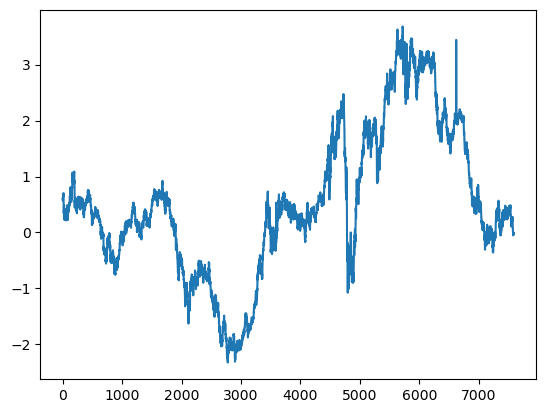

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

dataset = "Exchange" # Choix du dataset
path = f"./datasets/{dataset}/M/df_y.csv"  

# Chargement du fichier CSV
df = pd.read_csv(path)

# Affichage des premières lignes pour vérifier
print(df.head())

a= df["y"][0:5].values
print(a)
print(type(a))


unique_ids = df["unique_id"].unique() # On recupere tout les id dispo (car multivariate dataset)
print("id disponible :", unique_ids)

multivariate_data= df["y"]
data= multivariate_data[df['unique_id'] == unique_ids[0]].values # Changer l'indice de l'id pour récupérer une autre grandeur du dataset
#print(data[df['unique_id'] == unique_ids[0]].values)

plt.figure()
plt.plot(range(len(data)),data)

In [2]:

total_size= len(data)
train_end=int(total_size*0.7)
val_end= int(total_size*(0.7+0.10))

# Splitting des données 
train_data= data[0:train_end]
val_data= data[train_end:val_end]
test_data= data[val_end:]

# Calcul de la moyenne et écart type sur les données d'entrainement pour la normalisation

mean = np.mean(train_data)
std = np.std(train_data)

# Normalisatio ndes set d'entrainements

train_data_normalized = (train_data - mean) / std
val_data_normalized = (val_data - mean) / std
test_data_normalized = (test_data - mean) /std

In [6]:
from torch.utils.data import DataLoader, TensorDataset
import torch

def create_sequences(data, input_size, horizon):
    """
    Générez des séquences pour correspondre aux dimensions d'entrée et de sortie du modèle.

    Args:
        x_data (torch.Tensor): Données des entrées (features), de type torch.Tensor.
        y_data (torch.Tensor): Données des cibles (valeurs à prédire), de type torch.Tensor.
        input_size (int): Taille de la fenêtre d'entrée (nombre de pas de temps).
        horizon (int): Taille de l'horizon de prévision (nombre de pas de temps).

    Returns:
        torch.Tensor, torch.Tensor: Séquences d'entrée (x) et de sortie (y).
    """
    x, y = [], []
    for i in range(len(data) - input_size - horizon):
        x.append(data[i : i + input_size])  # Fenêtre d'entrée
        y.append(data[i + input_size : i + input_size + horizon])  # Fenêtre de sortie (horizon)

    return torch.tensor(x,dtype=torch.float32), torch.tensor(y,dtype=torch.float32)


H=96
L= 5*H
batch_size=256

# -------------- Création des fenêtres glissantes -----------
X_train,Y_train= create_sequences(data=train_data_normalized, input_size=L, horizon=H)
X_val,Y_val= create_sequences(data=val_data_normalized, input_size=L, horizon=H)

#-------------- Verification--------------------------
print("Shape of X_train : ", X_train.shape)
print("Shape of Y_train : ", Y_train.shape)
print(len(train_data_normalized)-L-H)
print(L)

print(X_train[0][0:5])
print(X_train[1][0:5])
print(X_train[2][0:5])
#-------------- Création des dataloader--------------------------
train_dataset = TensorDataset(X_train, Y_train)
val_dataset = TensorDataset(X_val, Y_val)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

#-------------- Verification--------------------------

for x,y in train_loader:
    print(x.size())
    print(y.size())
    print(x[0][0:5])
    break

Shape of X_train :  torch.Size([39744, 480])
Shape of Y_train :  torch.Size([39744, 96])
39744
480
tensor([ 0.0137, -0.1358, -0.2106, -0.5427, -0.3434])
tensor([-0.1358, -0.2106, -0.5427, -0.3434, -0.3351])
tensor([-0.2106, -0.5427, -0.3434, -0.3351, -0.4680])
torch.Size([256, 480])
torch.Size([256, 96])
tensor([ 0.0137, -0.1358, -0.2106, -0.5427, -0.3434])


### Entrainement 

In [7]:
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from nhits import Block, Stack, NHITS

# à activer pour visualiser sur tensorboard les logs
#%load_ext tensorboard
#%tensorboard --logdir lightning_logs


H=96
L= 5*H

batch_size=256
input_size = L # Taille de l'entrée
horizon = H
hidden_sizes = [512,512]
kernel_size = 2
expressiveness_ratio = [1./24,1./12,1.]
nb_block = 1
nb_stack = 3

class NHITSModel(pl.LightningModule):
    def __init__(self, nb_stack, nb_block, input_size, horizon, hidden_sizes, kernel_size, expressiveness_ratio, learning_rate=1e-3):
        super(NHITSModel, self).__init__()
        self.save_hyperparameters()
        self.model = NHITS(nb_stack, nb_block, input_size, horizon, hidden_sizes, kernel_size, expressiveness_ratio)
        self.criterion = nn.MSELoss()
        self.learning_rate = learning_rate

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch  
        y_pred = self.model(x)
        loss = self.criterion(y_pred, y)
        #print(f"Training loss: {loss}")
        self.log("train_loss", loss, on_epoch=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch  
        y_pred = self.model(x)
        loss = self.criterion(y_pred, y)
        #print(f"Validation loss: {loss.item()}")
        self.log("Validation_loss", loss, on_epoch=True)
        return loss


    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.learning_rate)
    

model = NHITSModel(
    nb_stack, nb_block, input_size, horizon, hidden_sizes, kernel_size, expressiveness_ratio
)

trainer = pl.Trainer(max_epochs=1, log_every_n_steps=1)

# Entrainement
trainer.fit(model, train_loader,val_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | model     | NHITS   | 1.3 M  | train
1 | criterion | MSELoss | 0      | train
----------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.076     Total estimated model params size (MB)
36        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\YOUNES\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\YOUNES\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
